In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

from pathlib import Path



## 1. Prepare the environment

In [2]:
def extract_data_from_moku(filename):

    # Skip the metadata lines (first 12) and read the data
    df = pd.read_csv(filename, skiprows=12, comment='%', header=None)

    # Rename columns for clarity (optional)
    df.columns = ['Time (s)', 'Probe A (V)', 'Probe B (V)']

    # Extract Probe A values as a list
    probe_a_values = df['Probe A (V)'].tolist()

    return probe_a_values


In [3]:
def extract_data_from_moku_1channel(filename):

    # Skip the metadata lines (first 12) and read the data
    df = pd.read_csv(filename, skiprows=12, comment='%', header=None)

    # Rename columns for clarity (optional)
    df.columns = ['Time (s)', 'Probe A (V)']

    # Extract Probe A values as a list
    #probe_a_values = df['Probe A (V)'].tolist()
    probe_a_values = df['Probe A (V)'].tolist()

    return probe_a_values

In [12]:
def downsample_v2(signal, factor):
    """
    Downsamples a signal by keeping the peak (max absolute) in each window.
    
    Parameters:
    - signal (list of float): Input signal with spikes.
    - factor (int): Downsampling factor (size of each chunk).

    Returns:
    - list of float: Downsampled signal with key spikes preserved.
    """
    if factor <= 0:
        raise ValueError("Downsampling factor must be a positive integer.")
    
    downsampled = []
    for i in range(0, len(signal), factor):
        window = signal[i:i + factor]
        if window:
            # Preserve the point with the largest absolute value (most spike-like)
            spike = max(window, key=abs)
            downsampled.append(spike)
    
    return downsampled


In [5]:
def extract_data_from_moku_minmax(filename, type='min'):

    # Skip the metadata lines (first 12) and read the data
    df = pd.read_csv(filename, skiprows=12, comment='%', header=None)
  

    # Rename column
    if len(df.columns) == 3: 
        df.columns = ['Time (s)', 'Probe A min (V)', 'Probe A max (V)']
    elif len(df.columns) == 5: 
        df.columns = ['Time (s)', 'Probe A min (V)', 'Probe A max (V)', 'Probe B min (V)', 'Probe B max (V)']
    else:
        print('Format error')

    # Extract Probe A values as a list
    #probe_a_values = df['Probe A (V)'].tolist()
    if type == 'min':
        probe_a_values = df['Probe A min (V)'].tolist()
    else:
        probe_a_values = df['Probe A max (V)'].tolist()

    return probe_a_values

In [6]:
def downsample(signal, downsample_factor=4, glitch_threshold=1.5):
    x = np.array(signal)
    trimmed_len = len(x) // downsample_factor * downsample_factor
    x_trimmed = x[:trimmed_len].reshape(-1, downsample_factor)

    # Compute z-score within each chunk
    means = np.mean(x_trimmed, axis=1, keepdims=True)
    stds = np.std(x_trimmed, axis=1, keepdims=True) + 1e-8  # avoid div by 0
    z_scores = (x_trimmed - means) / stds

    # Identify glitches (z-score > threshold)
    is_glitch = np.abs(z_scores) > glitch_threshold

    downsampled = []
    for i, chunk in enumerate(x_trimmed):
        if np.any(is_glitch[i]):
            # If any glitches in chunk, preserve all (or pick the glitch value)
            glitch_vals = chunk[is_glitch[i]]
            downsampled.append(glitch_vals[0])  # or append all glitches if needed
        else:
            # Otherwise, take the average (or median)
            downsampled.append(np.mean(chunk))

    return np.array(downsampled)


## 2. Load the file with data saved from the normal noisy sine signal 

In [7]:

#filepath = "training_dataset_from_moku/raw/Normal_20250520_081426_10kSa.csv" # Insert here the path to your saved files
filepath = "Normal_2305_1_20250523_122020.csv"
probe_a_values_min = extract_data_from_moku_minmax(filepath, 'min')
probe_a_values_max = extract_data_from_moku_minmax(filepath, 'max')

filepath_2 = "Normal_2305_2_20250523_133119.csv"
probe_a_values_min_2 = extract_data_from_moku_minmax(filepath_2, 'min')
probe_a_values_max_2 = extract_data_from_moku_minmax(filepath_2, 'max')



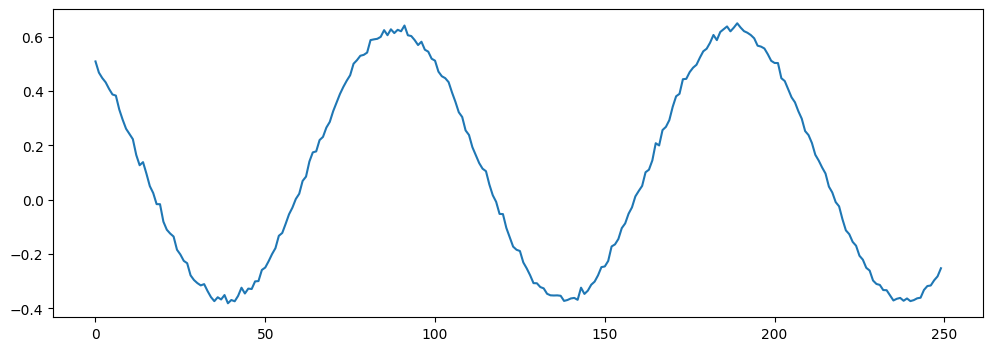

In [10]:
# Let's plot the first 250 datatpoints to confirm the signal is as expected
plt.figure(figsize=(12, 4)) 
x_max_sample = probe_a_values_max[:250]
plt.plot(x_max_sample)

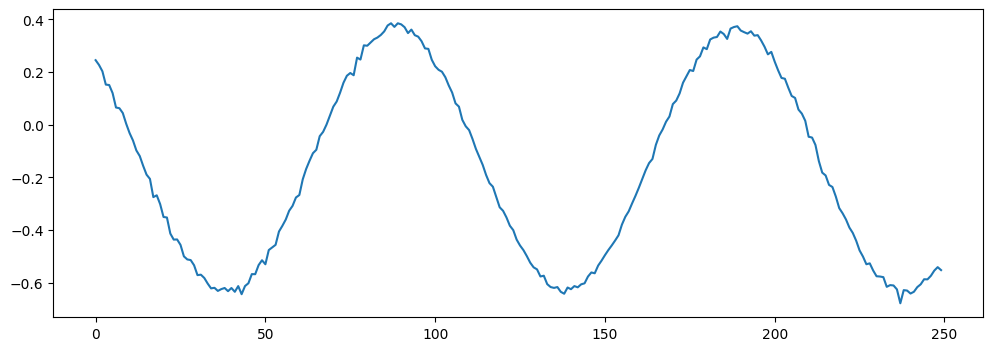

In [ ]:
# Let's plot the first 250 datatpoints to confirm the signal is as expected
plt.figure(figsize=(12, 4)) 
x_min_sample = probe_a_values_min[:250]
plt.plot(x_min_sample)

In [14]:
def downsample_values(min_values, max_values, factor):

    values_min = min_values
    values_max = max_values

    downsampled_signal_min = downsample_v2(values_min,factor)
    downsampled_signal_max = downsample_v2(values_max,factor) 

    print(f'Downsampled signal - min length: {len(downsampled_signal_min)}')
    print(f'Downsampled signal - max length: {len(downsampled_signal_max)}') 

    return downsampled_signal_min, downsampled_signal_max


In [19]:
downsampled_signal_max_sample = downsample_v2(x_max_sample,factor=5)

print('downsampling the first normal batch...')
downsampled_signal_min_tot, downsampled_signal_max_tot = downsample_values(probe_a_values_min, probe_a_values_max, factor=5)
print('--------------------------------------------')
print('downsampling the second normal batch...')
downsampled_signal_min_tot_2, downsampled_signal_max_tot_2 = downsample_values(probe_a_values_min_2, probe_a_values_max_2, factor=5)


downsampling the first normal batch...
Downsampled signal - min length: 60013
Downsampled signal - max length: 60013
--------------------------------------------
downsampling the second normal batch...
Downsampled signal - min length: 60013
Downsampled signal - max length: 60013


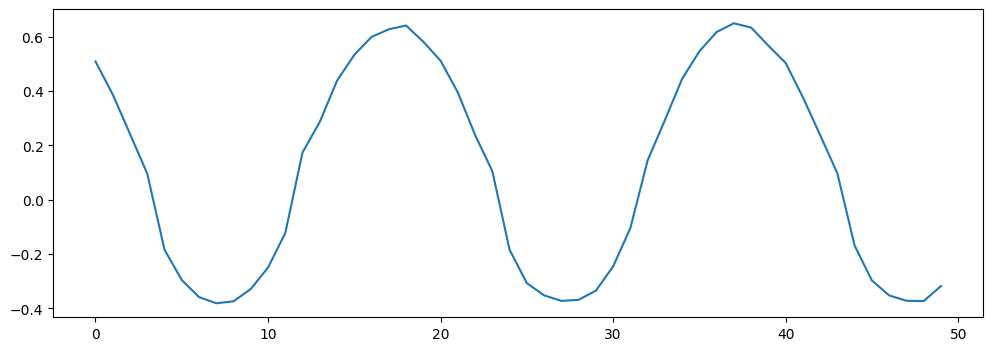

In [20]:
plt.figure(figsize=(12, 4)) 
plt.plot(downsampled_signal_max_sample)

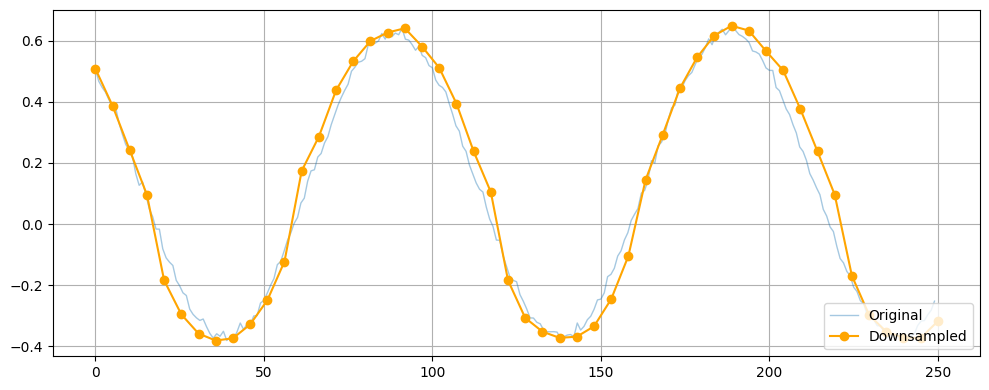

The signal has been downsampled from 250 to 50 datapoints


In [21]:

plt.figure(figsize=(10, 4))
plt.plot(x_max_sample, label='Original', linewidth=1, alpha=0.4)
plt.plot(np.linspace(0, len(x_max_sample), len(downsampled_signal_max_sample)), downsampled_signal_max_sample, 'o-', label='Downsampled', color='orange')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f'The signal has been downsampled from {len(x_max_sample)} to {len(downsampled_signal_max_sample)} datapoints')

In [23]:
window_size = 50

# Max peaks
values = downsampled_signal_max_tot + downsampled_signal_max_tot_2
num_windows = len(values) // window_size
print(f'Generating and saving {num_windows} frames from the max time series')

# Open CSV file to write
with open("training_peak_max_normal_20250523.csv", "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["sample_n", "data"])  # Write header

    for i in range(num_windows):
        start_idx = i * window_size
        end_idx = start_idx + window_size
        chunk = values[start_idx:end_idx]

        writer.writerow([i + 1, ",".join(map(str, chunk))])


# Min peaks
values = downsampled_signal_min_tot + downsampled_signal_min_tot_2
num_windows = len(values) // window_size
print(f'Generating and saving {num_windows} frames from the min time series')

# Open CSV file to write
with open("training_peak_min_normal_20250523.csv", "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["sample_n", "data"])  # Write header

    for i in range(num_windows):
        start_idx = i * window_size
        end_idx = start_idx + window_size
        chunk = values[start_idx:end_idx]

        writer.writerow([i + 1, ",".join(map(str, chunk))])




Generating and saving 2400 frames from the max time series
Generating and saving 2400 frames from the min time series


## 3. Load the file with data saved from the signal with anomaly in peak mode

In [24]:
#filepath_anomalies = "training_dataset_from_moku/raw/Anomaly_55Hz_20250519_144735.csv" # Insert here the path to your saved files
filepath_anomalies = "training_dataset_from_moku/raw/Aomaly_2305_20250523_105400.csv"
probe_a_values_anomalies_min = extract_data_from_moku_minmax(filepath_anomalies, 'min')
probe_a_values_anomalies_max = extract_data_from_moku_minmax(filepath_anomalies, 'max')



MAx values - collected 300061 datapoints


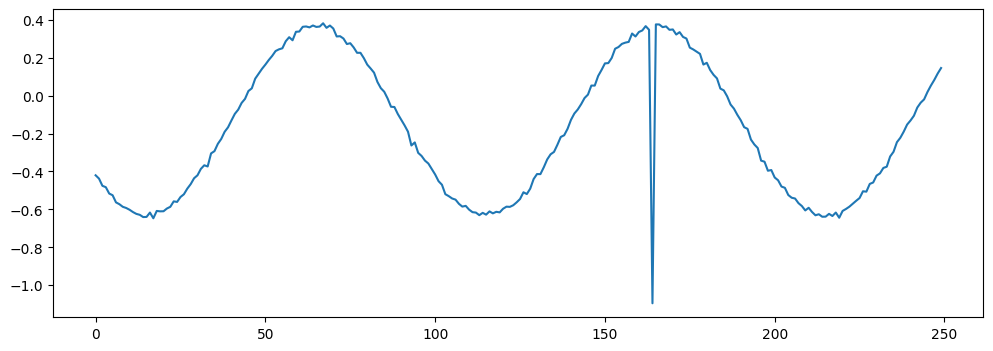

In [25]:
# Let's plot the first 500 datatpoints to confirm the signal is as expected
plt.figure(figsize=(12, 4)) 
x_anomalies = probe_a_values_anomalies_min[:250]
plt.plot(x_anomalies)
print(f"MAx values - collected {len(probe_a_values_anomalies_min)} datapoints")

Max values - collected 300061 datapoints


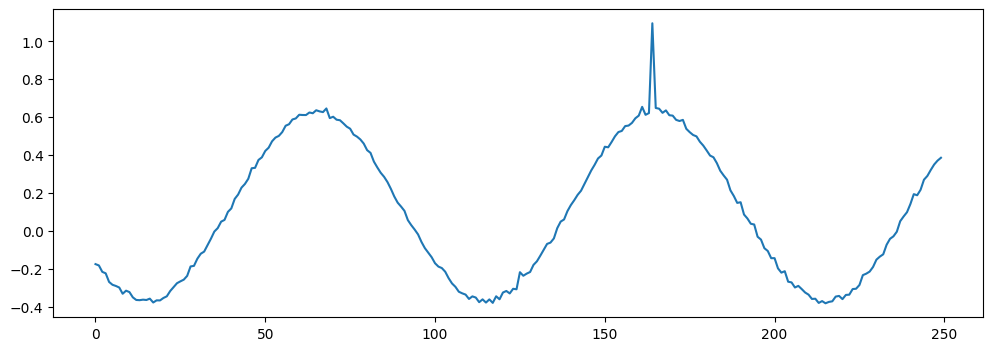

In [26]:
# Let's plot the first 100 datatpoints to confirm the signal is as expected
plt.figure(figsize=(12, 4)) 
x_anomalies_max = probe_a_values_anomalies_max[:250]
plt.plot(x_anomalies_max)
print(f"Max values - collected {len(probe_a_values_anomalies_max)} datapoints")

In [27]:
x_anomalies_min_tot = probe_a_values_anomalies_min
x_anomalies_max_tot = probe_a_values_anomalies_max

In [28]:
downsampled_signal_anomalies_max_sample = downsample_v2(x_anomalies_max,factor=5)
downsampled_signal_anomalies_min_tot = downsample_v2(x_anomalies_min_tot,factor=5)
downsampled_signal_anomalies_max_tot = downsample_v2(x_anomalies_max_tot,factor=5)

print(f'Downsampled signal - min length: {len(downsampled_signal_anomalies_min_tot)}')
print(f'Downsampled signal - max length: {len(downsampled_signal_anomalies_max_tot)}')

Downsampled signal - min length: 60013
Downsampled signal - max length: 60013


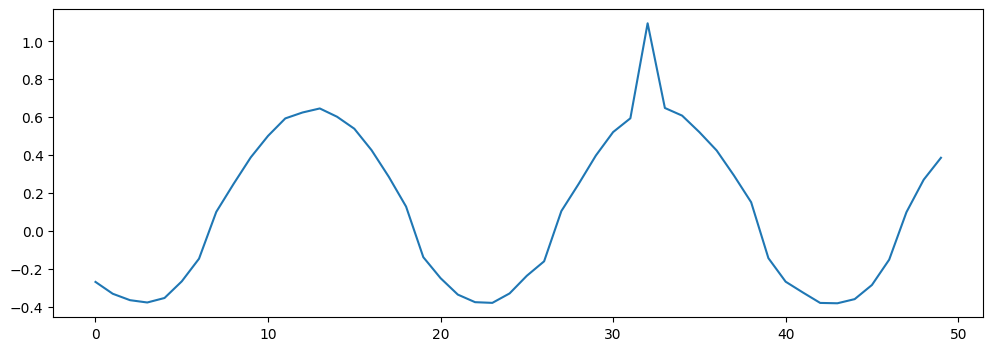

In [29]:
plt.figure(figsize=(12, 4)) 
plt.plot(downsampled_signal_anomalies_max_sample)

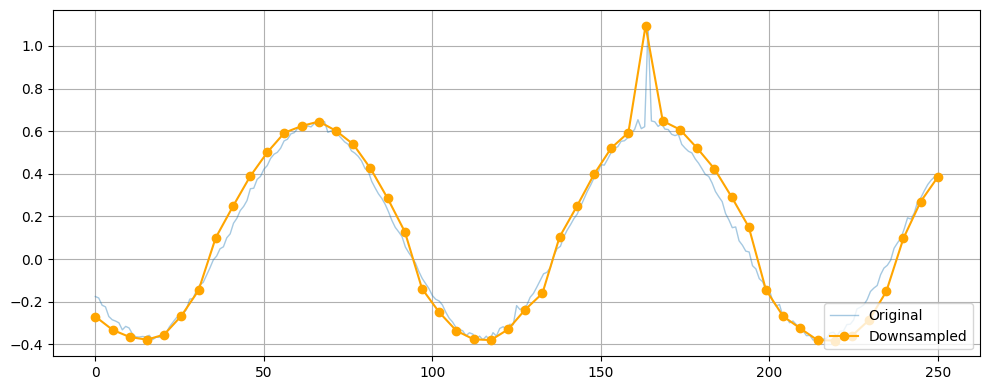

The signal has been downsampled from 250 to 50 datapoints


In [30]:

# Plotting
plt.figure(figsize=(10, 4))
plt.plot(x_anomalies_max, label='Original', linewidth=1, alpha=0.4)
plt.plot(np.linspace(0, len(x_anomalies_max), len(downsampled_signal_anomalies_max_sample)), downsampled_signal_anomalies_max_sample, 'o-', label='Downsampled', color='orange')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f'The signal has been downsampled from {len(x_anomalies_max)} to {len(downsampled_signal_anomalies_max_sample)} datapoints')

In [31]:
window_size = 50

# Max peaks
values = downsampled_signal_anomalies_max_tot
num_windows = len(values) // window_size
print(f'Generating and saving {num_windows} frames from the max time series')

# Open CSV file to write
with open("training_peak_max_20250523.csv", "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["sample_n", "data"])  # Write header

    for i in range(num_windows):
        start_idx = i * window_size
        end_idx = start_idx + window_size
        chunk = values[start_idx:end_idx]

        writer.writerow([i + 1, ",".join(map(str, chunk))])


# Min peaks
values = downsampled_signal_anomalies_min_tot
num_windows = len(values) // window_size
print(f'Generating and saving {num_windows} frames from the min time series')

# Open CSV file to write
with open("training_peak_min_20250523.csv", "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["sample_n", "data"])  # Write header

    for i in range(num_windows):
        start_idx = i * window_size
        end_idx = start_idx + window_size
        chunk = values[start_idx:end_idx]

        writer.writerow([i + 1, ",".join(map(str, chunk))])




Generating and saving 1200 frames from the max time series
Generating and saving 1200 frames from the min time series
